In [1]:
# load stuff:
import scipy.optimize as so
import datetime as dt


from dataload_helper import Dataset
from dataeval_helper import *  # load here also numpy, scipy,...
from global_params import *

In [2]:
#load Datasets
#SETNAME="MERRA"
SETNAME="MERRA2_2D"
#SETNAME="JRA-55"

#Global Params
if SETNAME=="MERRA":
    FILES="../Data/Merra_inst3_3d_asm_Cp_1979-2016/instM_3d_asm_Cp_197901_201601.nc"
    RESLOC = '../Results/'
    RESLOC_SPECIFIC = 'MERRA_ST/'
    DATALOC_SPECIFIC = 'Merra_inst3_3d_asm_Cp_1979-2016/'
    DATALOC = '../Data/' + DATALOC_SPECIFIC
elif SETNAME=="MERRA2_2D":
    FILES="../../../../../../work/mh0066/m301053/Data/MERRA2_instM_3d_asm_Np_PS,RH,T/MERRA2_*"
    RESLOC = '../Results/'
    RESLOC_SPECIFIC = 'MERRA2_ST/'
    DATALOC_SPECIFIC = 'MERRA2_instM_3d_asm_Np_PS,RH,T/'
    DATALOC = '../../../../../../work/mh0066/m301053/Data/' + DATALOC_SPECIFIC
elif SETNAME=="JRA-55":
    FILES="../Data/JRA-55_Monthly_1.25_Deg_isobaric/anl*"
    RESLOC = '../Results/'
    RESLOC_SPECIFIC = 'JRA-55_ST/'
    DATALOC_SPECIFIC = 'JRA-55_Monthly_1.25_Deg_isobaric/'
    DATALOC = '../Data/' + DATALOC_SPECIFIC
else:
    raise Exception("Sorry, notexisting Setname")
#What parts of the Notebook should run?
TOPOANALYSIS=False
#Times for analysis
t1_start='1980-01-01'
t1_end='1989-12-01'
t2_start='2010-01-01'
t2_end='2019-12-01'

In [3]:
DS = Dataset(files=FILES, setname = SETNAME, dataloc = DATALOC)
DS.init_surfacevals()

Loading full dataset MERRA2_2D
[########################################] | 100% Completed | 4.39 ss
<xarray.Dataset>
Dimensions:  (time: 240, lev: 42, lat: 361, lon: 576)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-12-01
Data variables:
    RH       (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    PS       (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    T        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    History:                           Original file generated: Thu May  7 22...
    Filename:                          MERRA2_100.instM_3d_asm_Np.198001.nc4
    Comment:       

In [4]:
Data2D = Dataset(files="../../../../../../work/mh0066/m301053/Data/MERRA2_instM_2d_asm_Nx/MERRA2_*", setname = "MERRA2_2D", dataloc = '../../../../../../work/mh0066/m301053/Data/MERRA2_instM_2d_asm_Nx/')

def norm(vmin,vmax,vcentner=0):
    global norm
    return mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcentner, vmax=vmax)

Loading full dataset MERRA2_2D
[########################################] | 100% Completed | 3.34 sms
<xarray.Dataset>
Dimensions:  (time: 240, lat: 361, lon: 576)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-12-01
Data variables:
    T2M      (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    TS       (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    T10M     (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    TQV      (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    QV2M     (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    QV10M    (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    History

In [5]:
# =======================================================================
#Initilize topography analysis
if TOPOANALYSIS==True:
    TOPO = Dataset(files="../../../../../../work/mh0066/m301053/Data/Topo/topo_r720x360.nc", setname = 'TOPO', dataloc = '../../../../../../work/mh0066/m301053/Data/Topo/')
    TOPO.land_mask = xr.where(TOPO.ds.topo >= 0.0, True, False)
    
    # Reindex the land mask to match the climate data grid
    TOPO.land_mask_reindexed = TOPO.land_mask.reindex_like(DS.ds, method='nearest')
    print(TOPO.land_mask_reindexed)
    #TOPO.ds.where(TOPO.land_mask_reindexed==False).topo.plot(ax=ax, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_elevation,cbar_kwargs= cbar_kwargs) for ocean


In [6]:
# =======================================================================
#Compare Temps

DT_T3D_T2M = -(DS.ds_surface.T - Data2D.ds.T2M)
DT_T3D_TS = -(DS.ds_surface.T - Data2D.ds.TS)
DT_T3D_T10M = -(DS.ds_surface.T - Data2D.ds.T10M)


DT_T3D_T2M.attrs = DS.ds_surface.T.attrs
DT_T3D_TS.attrs = DS.ds_surface.T.attrs
DT_T3D_T10M.attrs = DS.ds_surface.T.attrs


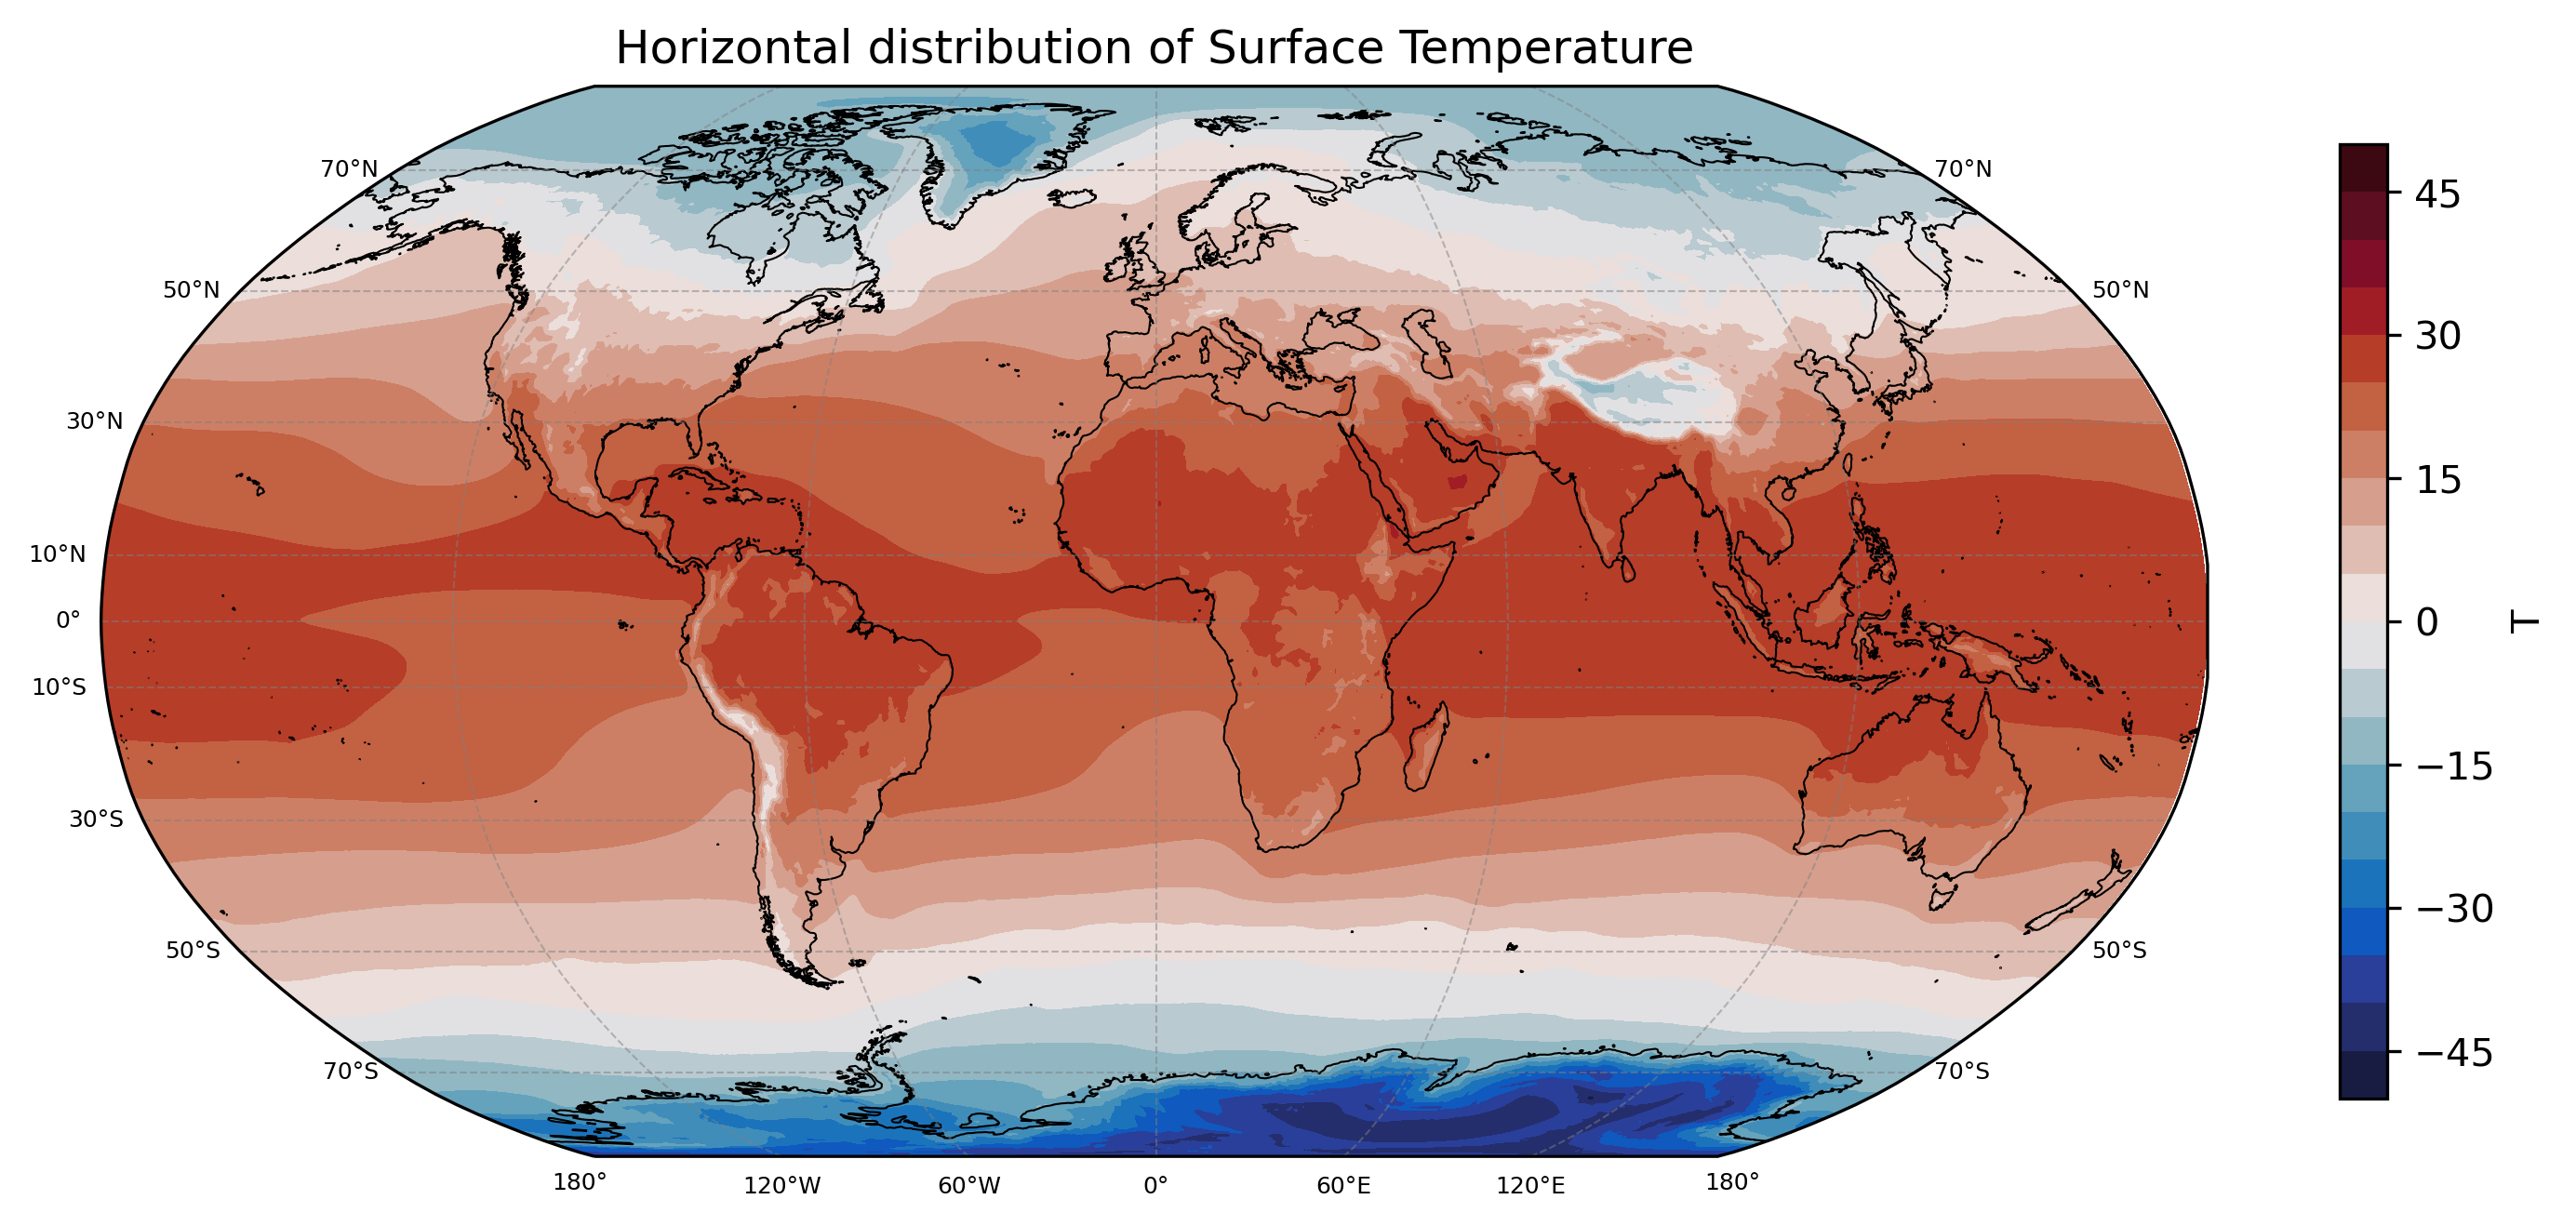

In [7]:
# Plot T @ T Surface and Timemean
    
fig, ax, gl, cbar_kwargs = create_empty_2d_map(projection=ccrs.Robinson())

K2Deg(time_mean(get_timeframe(DS.ds_surface.T,t2_start,t2_end))).T.plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_T,cbar_kwargs= cbar_kwargs)

ax.set_title('Horizontal distribution of Surface Temperature')
plt.tight_layout()
plt.savefig(RESLOC+RESLOC_SPECIFIC+'global_Temp_Distribution_from_3D.png',dpi=400)
plt.show()


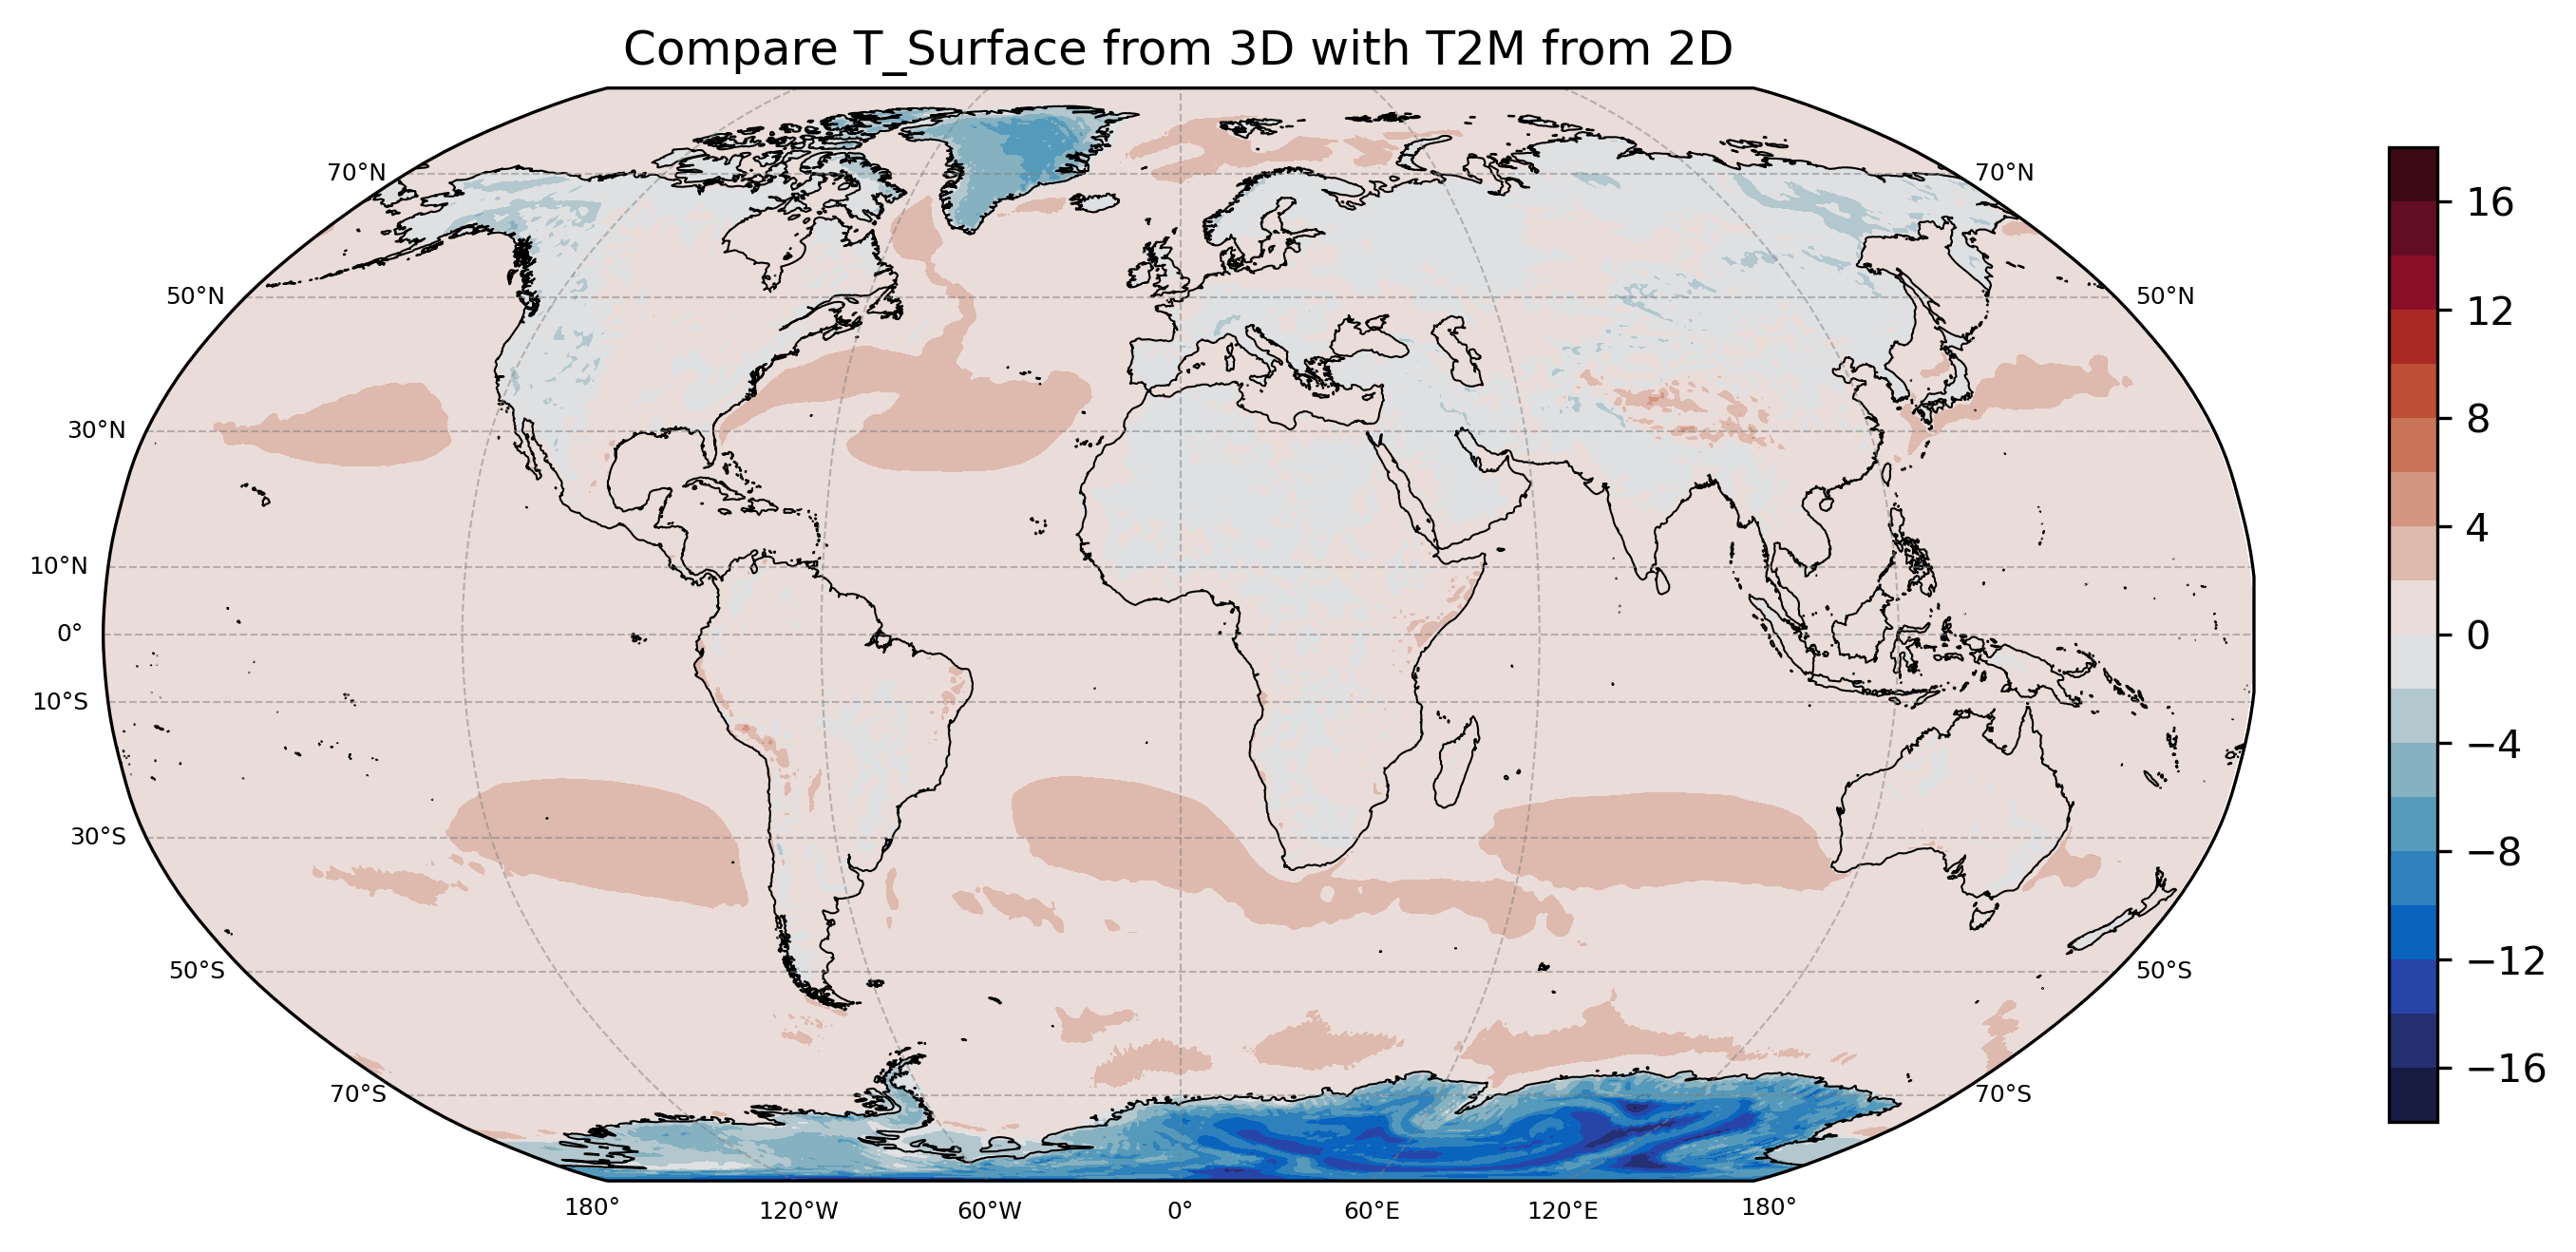

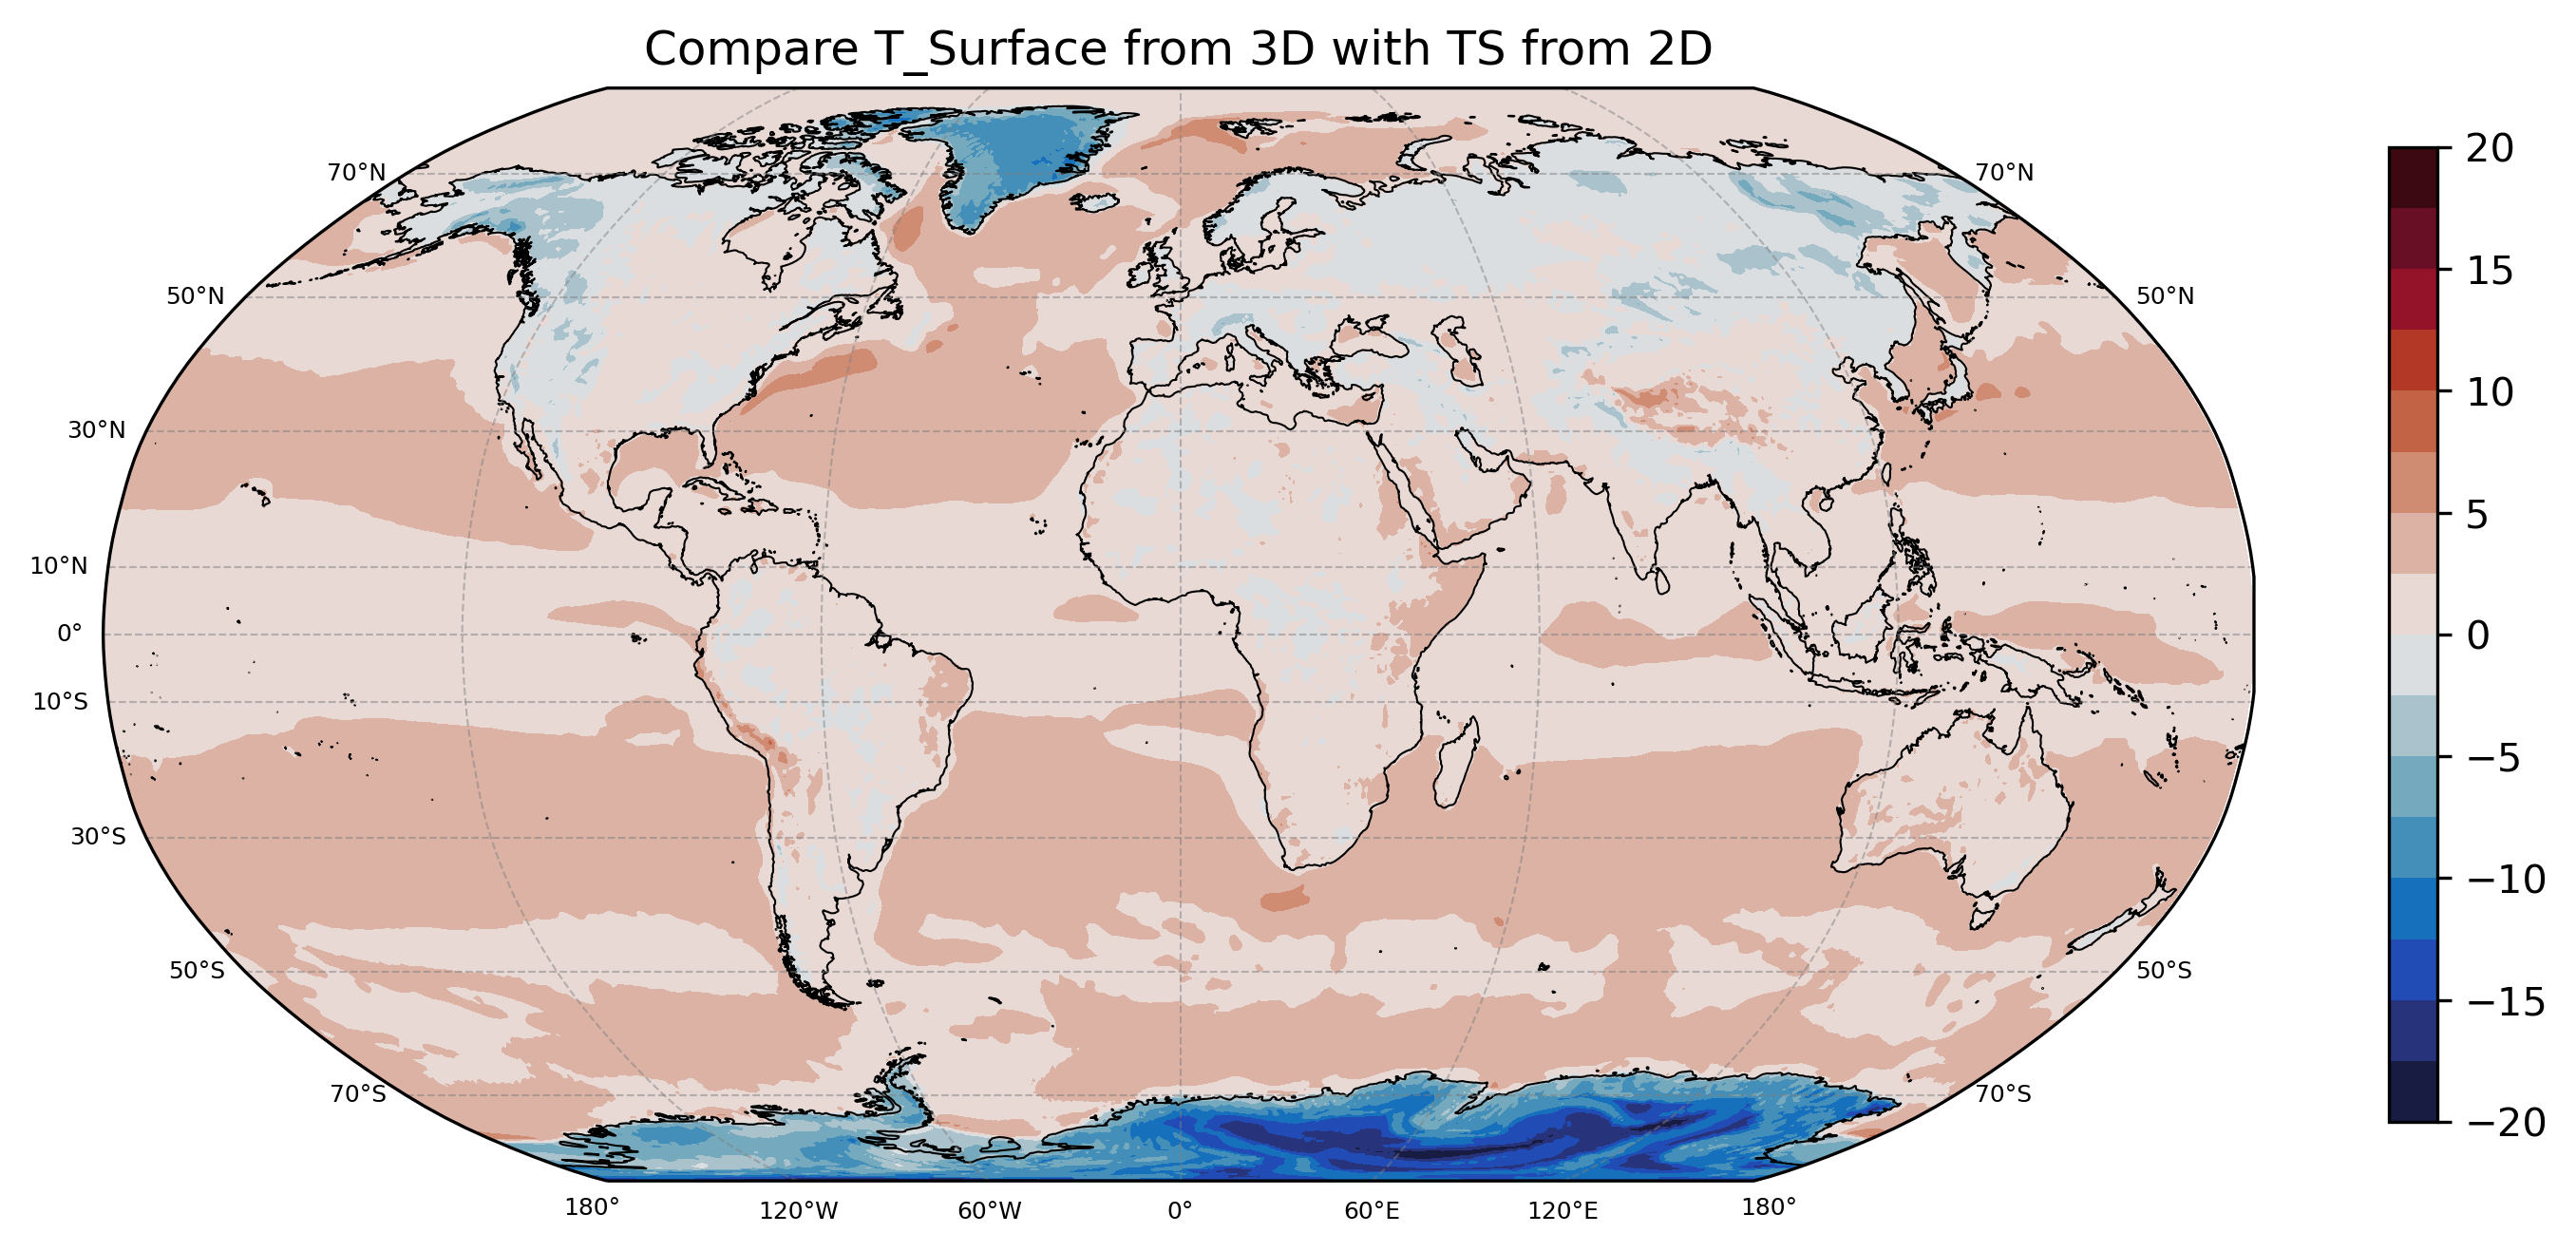

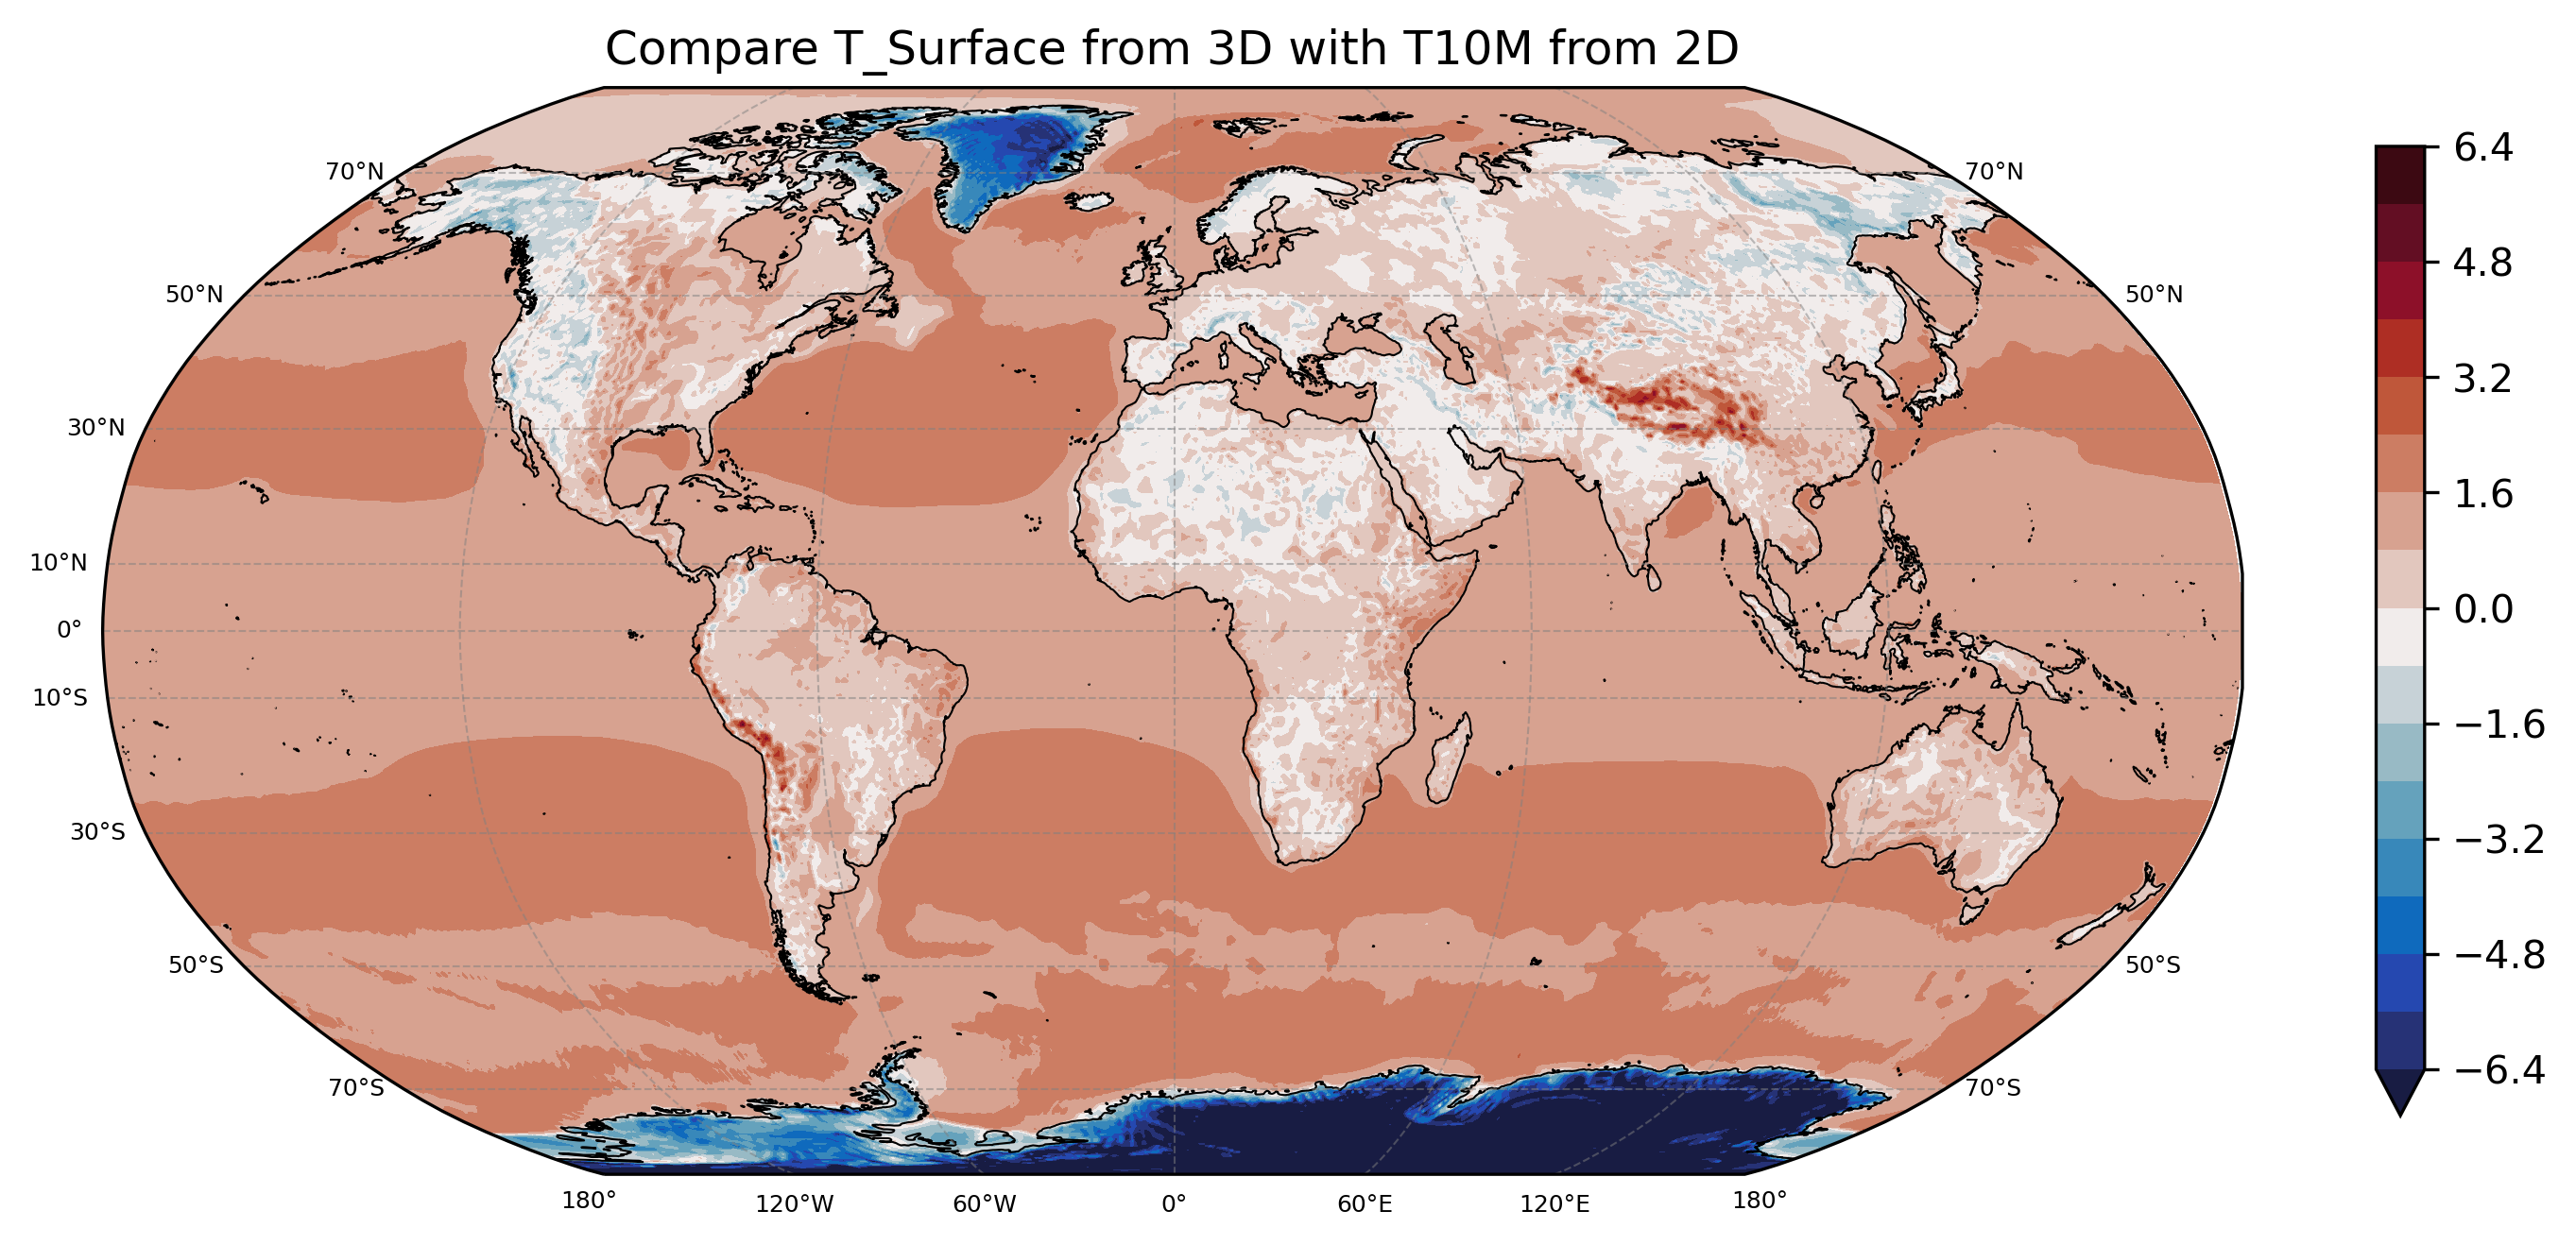

In [15]:
# Plot T @ T Surface and Timemean
    
fig, ax, gl, cbar_kwargs = create_empty_2d_map(projection=ccrs.Robinson())

time_mean(get_timeframe(DT_T3D_T2M,t2_start,t2_end)).T.plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_T,cbar_kwargs= cbar_kwargs)

ax.set_title('Compare T_Surface from 3D with T2M from 2D')
plt.tight_layout()
plt.savefig(RESLOC+RESLOC_SPECIFIC+'global_Temp_Distribution_DT_T3D_T2M.png',dpi=400)
plt.show()

# Plot T @ T Surface and Timemean
    
fig, ax, gl, cbar_kwargs = create_empty_2d_map(projection=ccrs.Robinson())

time_mean(get_timeframe(DT_T3D_TS,t2_start,t2_end)).T.plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_T,cbar_kwargs= cbar_kwargs)

ax.set_title('Compare T_Surface from 3D with TS from 2D')
plt.tight_layout()
plt.savefig(RESLOC+RESLOC_SPECIFIC+'global_Temp_Distribution_DT_T3D_TS.png',dpi=400)
plt.show()

# Plot T @ T Surface and Timemean
    
fig, ax, gl, cbar_kwargs = create_empty_2d_map(projection=ccrs.Robinson())

time_mean(get_timeframe(DT_T3D_T10M,t2_start,t2_end)).T.plot.contourf(ax=ax, levels=20,norm=norm(vmax=6,vmin=-6), transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_T,cbar_kwargs= cbar_kwargs)

ax.set_title('Compare T_Surface from 3D with T10M from 2D')
plt.tight_layout()
plt.savefig(RESLOC+RESLOC_SPECIFIC+'global_Temp_Distribution_DT_T3D_T10M.png',dpi=400)
plt.show()

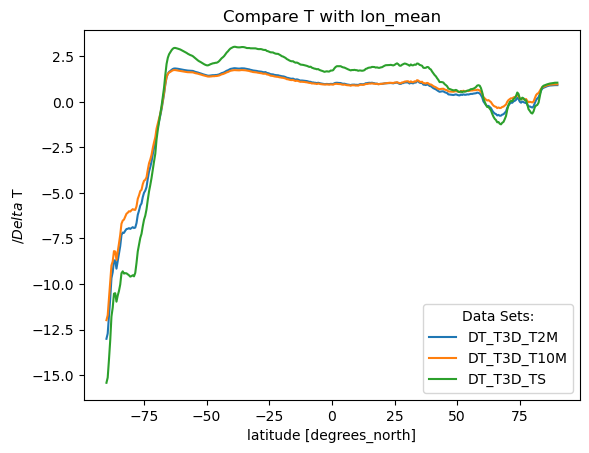

In [9]:

fig, ax = plt.subplots()


time_mean(get_timeframe(lon_mean(DT_T3D_T2M).T,t2_start,t2_end)).plot.line(label = 'DT_T3D_T2M')
time_mean(get_timeframe(lon_mean(DT_T3D_T10M).T,t2_start,t2_end)).plot.line( label = 'DT_T3D_T10M')
time_mean(get_timeframe(lon_mean(DT_T3D_TS).T,t2_start,t2_end)).plot.line( label = 'DT_T3D_TS')

ax.set_ylabel('$/Delta$ T')
ax.set_title('Compare T with lon_mean')
ax.legend(title = 'Data Sets:')
plt.savefig(RESLOC+RESLOC_SPECIFIC+'Compare_T_lon_mean.png',dpi=400)
plt.show()


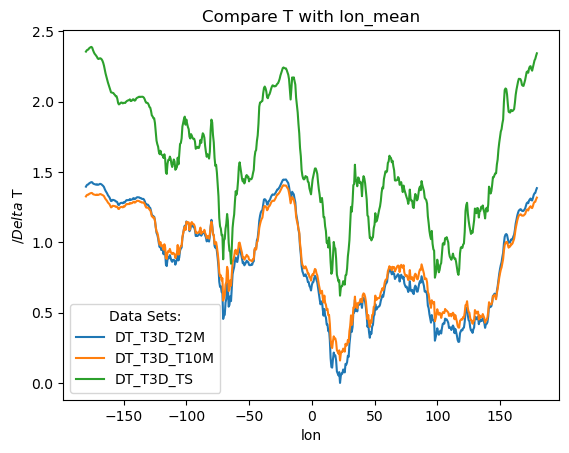

In [10]:
fig, ax = plt.subplots()


time_mean(get_timeframe(lat_mean(DT_T3D_T2M).T,t2_start,t2_end)).plot.line(label = 'DT_T3D_T2M')
time_mean(get_timeframe(lat_mean(DT_T3D_T10M).T,t2_start,t2_end)).plot.line( label = 'DT_T3D_T10M')
time_mean(get_timeframe(lat_mean(DT_T3D_TS).T,t2_start,t2_end)).plot.line( label = 'DT_T3D_TS')

ax.set_ylabel('$/Delta$ T')
ax.set_title('Compare T with lon_mean')
ax.legend(title = 'Data Sets:')
plt.savefig(RESLOC+RESLOC_SPECIFIC+'Compare_T_lat_mean.png',dpi=400)
plt.show()

In [11]:
# =======================================================================
#Compare RH

DRH_RH3D_QV2M = -(DS.ds_surface.RH*0.01 - Data2D.ds.QV2M)
DRH_RH3D_QV10M = -(DS.ds_surface.RH*0.01 - Data2D.ds.QV10M)


DRH_RH3D_QV2M.attrs = DS.ds_surface.RH.attrs
DRH_RH3D_QV10M.attrs = DS.ds_surface.RH.attrs



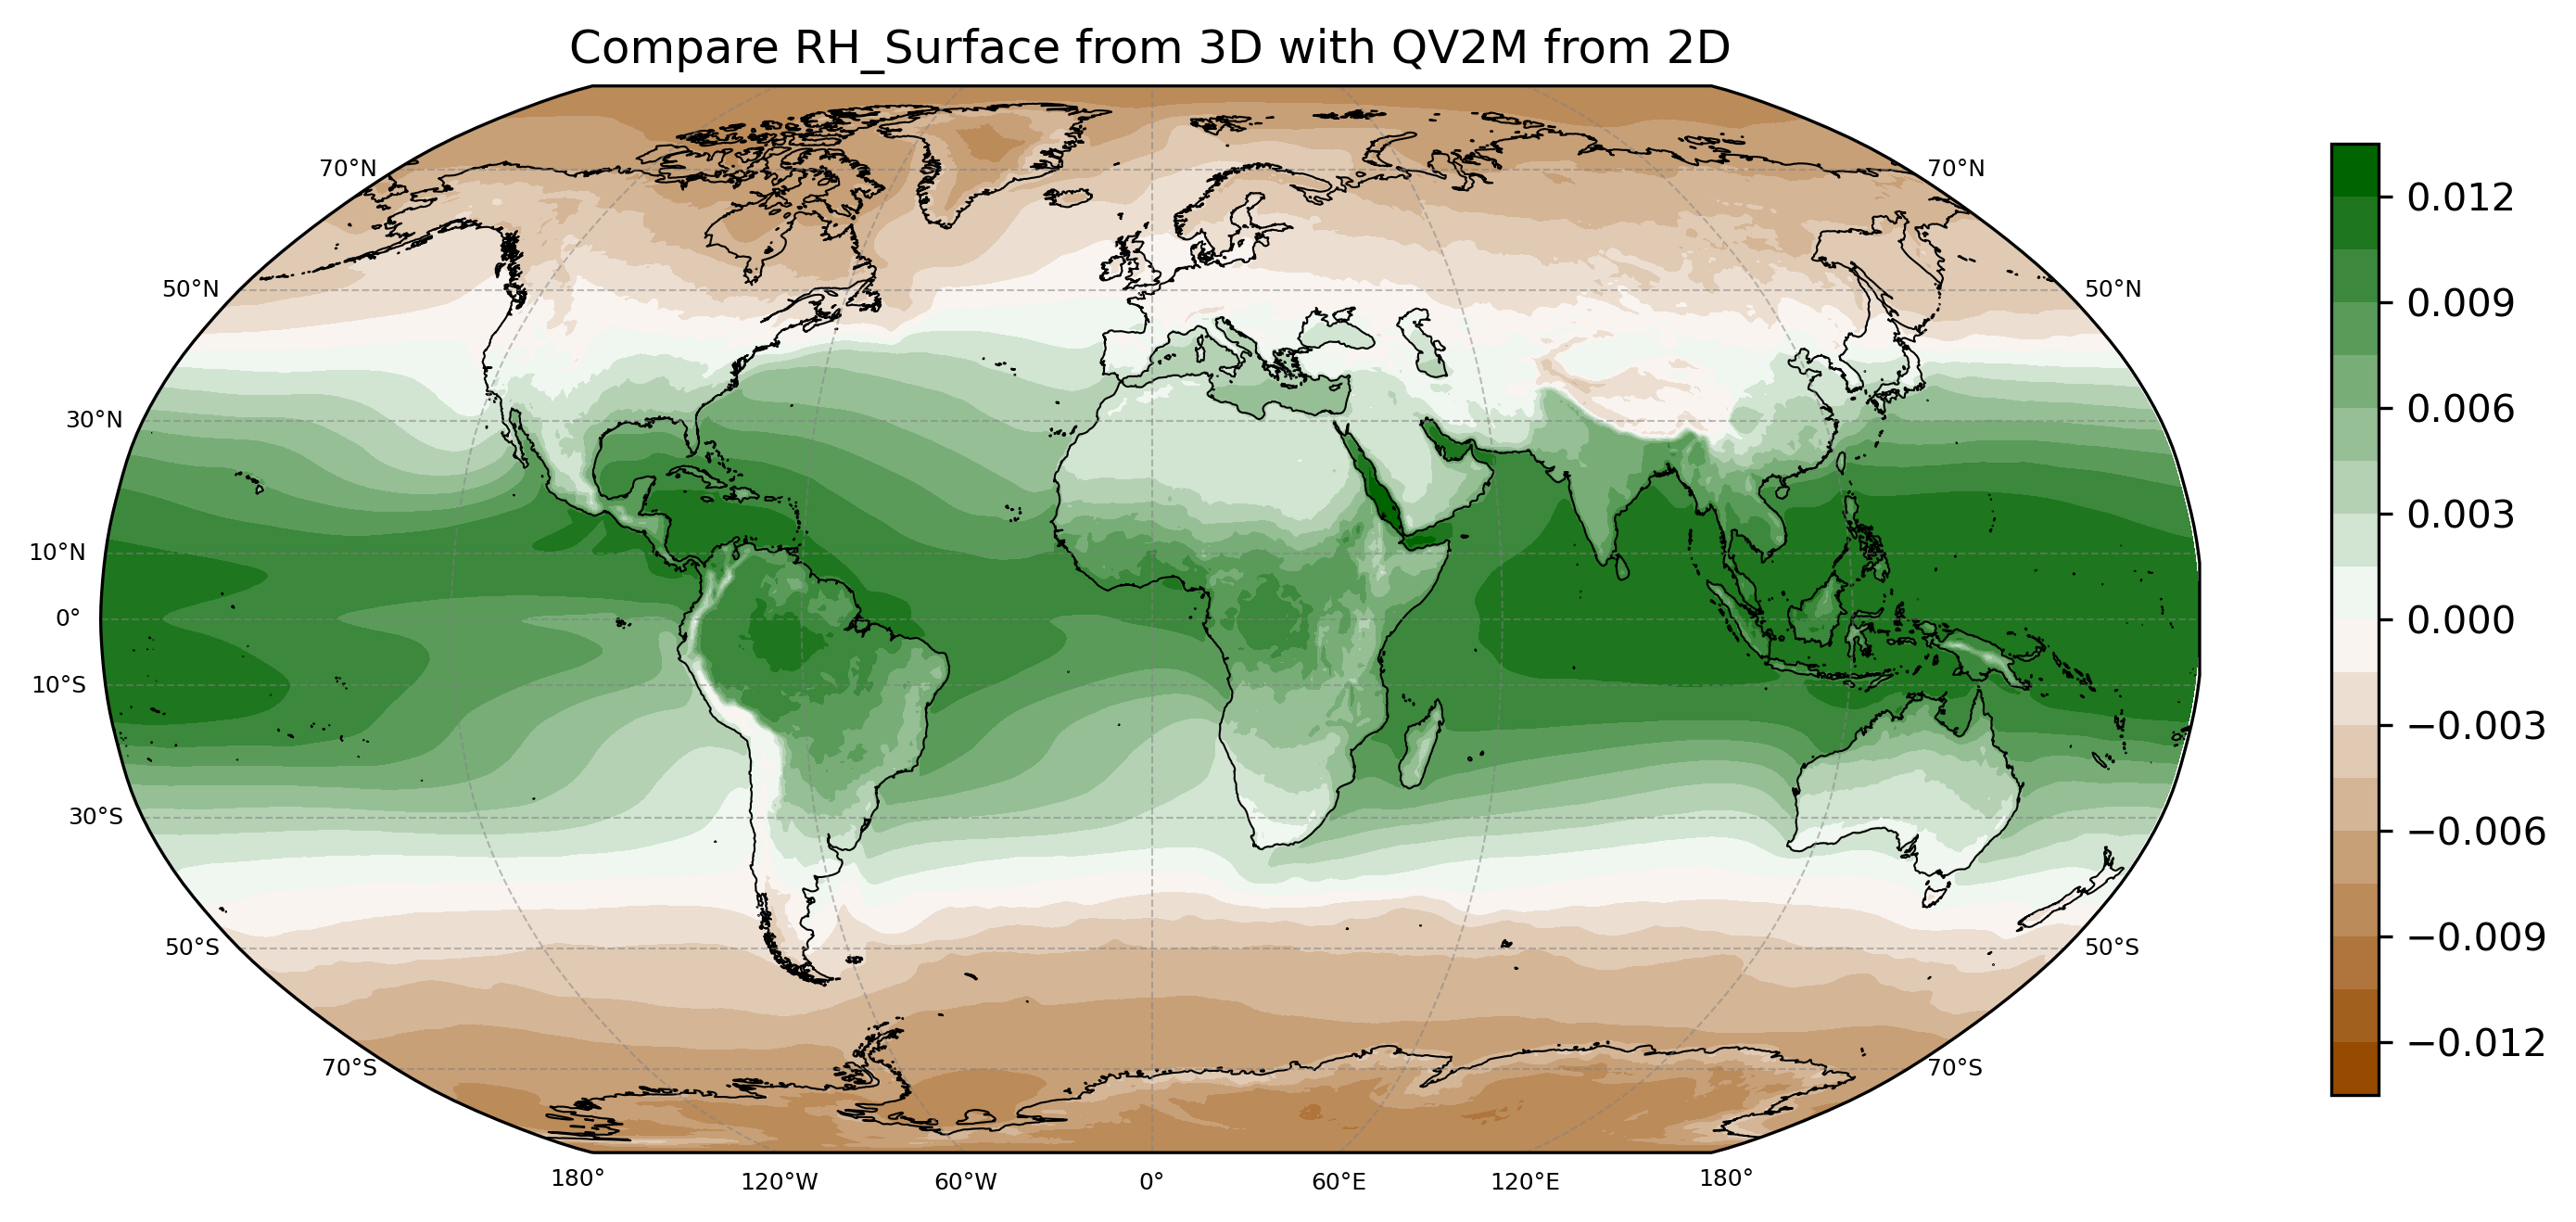

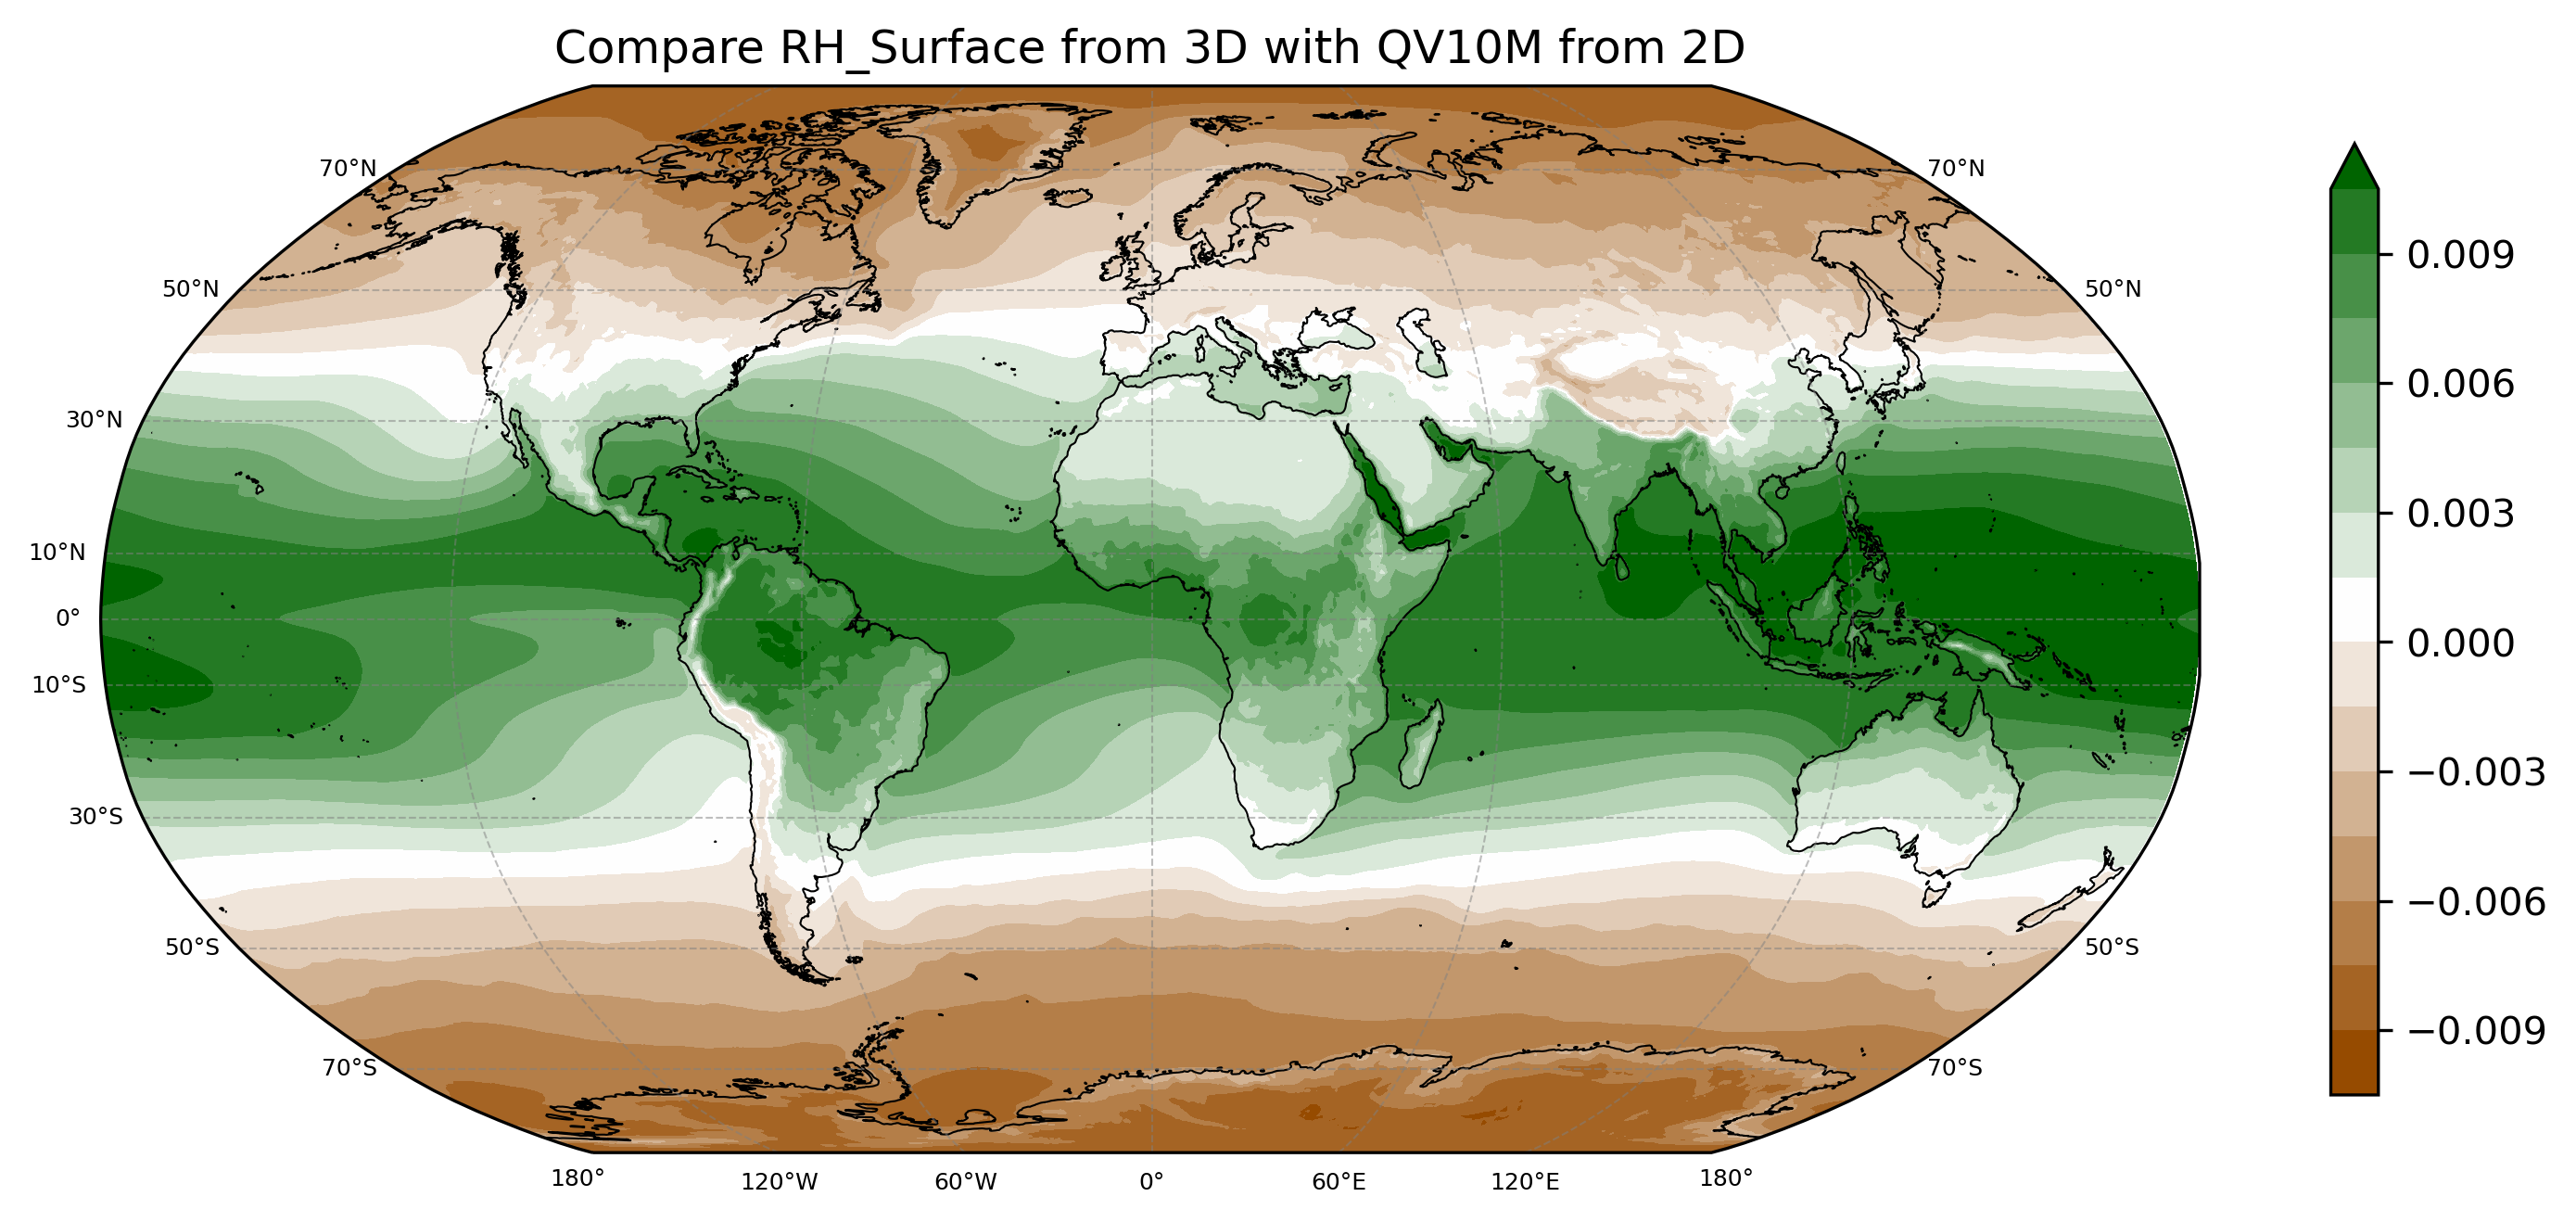

In [21]:

# Plot RH 
    
fig, ax, gl, cbar_kwargs = create_empty_2d_map(projection=ccrs.Robinson())

time_mean(get_timeframe(DRH_RH3D_QV2M,t2_start,t2_end)).plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_RH_change,cbar_kwargs= cbar_kwargs)

ax.set_title('Compare RH_Surface from 3D with QV2M from 2D')
plt.tight_layout()
plt.savefig(RESLOC+RESLOC_SPECIFIC+'global_RHemp_Distribution_DRH_RH3D_QV2M.png',dpi=400)
plt.show()

# Plot RH 
    
fig, ax, gl, cbar_kwargs = create_empty_2d_map(projection=ccrs.Robinson())

time_mean(get_timeframe(DRH_RH3D_QV10M,t2_start,t2_end)).plot.contourf(ax=ax, levels=20,norm=norm(vmax=0.01,vmin=-0.01), transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_RH_change,cbar_kwargs= cbar_kwargs)

ax.set_title('Compare RH_Surface from 3D with QV10M from 2D')
plt.tight_layout()
plt.savefig(RESLOC+RESLOC_SPECIFIC+'global_RHemp_Distribution_DRH_RH3D_QV10M.png',dpi=400)
plt.show()

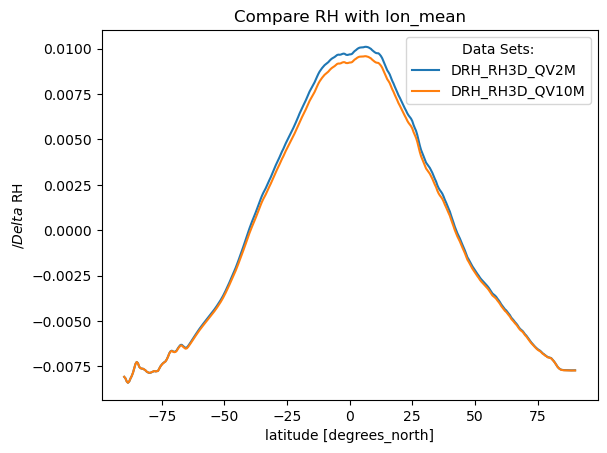

In [13]:
fig, ax = plt.subplots()


time_mean(get_timeframe(lon_mean(DRH_RH3D_QV2M),t2_start,t2_end)).plot.line(label = 'DRH_RH3D_QV2M')
time_mean(get_timeframe(lon_mean(DRH_RH3D_QV10M),t2_start,t2_end)).plot.line( label = 'DRH_RH3D_QV10M')

ax.set_ylabel('$/Delta$ RH')
ax.set_title('Compare RH with lon_mean')
ax.legend(title = 'Data Sets:')
plt.savefig(RESLOC+RESLOC_SPECIFIC+'Compare_RH_lon_mean.png',dpi=400)
plt.show()


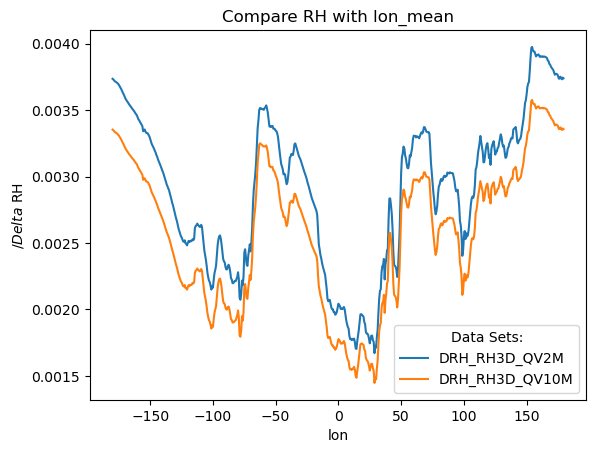

In [14]:
fig, ax = plt.subplots()


time_mean(get_timeframe(lat_mean(DRH_RH3D_QV2M),t2_start,t2_end)).plot.line(label = 'DRH_RH3D_QV2M')
time_mean(get_timeframe(lat_mean(DRH_RH3D_QV10M),t2_start,t2_end)).plot.line( label = 'DRH_RH3D_QV10M')

ax.set_ylabel('$/Delta$ RH')
ax.set_title('Compare RH with lon_mean')
ax.legend(title = 'Data Sets:')
plt.savefig(RESLOC+RESLOC_SPECIFIC+'Compare_RH_lat_mean.png',dpi=400)
plt.show()
